# Imports

In [1]:
import os
import re
import random
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Function and class definitions

In [2]:
class cavka_data():
    """description"""
    def __init__(self, path):
        self.path = path
        self.method = {}
        self.acqp = {}
        self.k_space = np.array([])

        self.read_bruker_rawdata()

    def read_bruker_rawdata(self):
        """description"""
        acqp = open(os.path.join(self.path,'acqp'), 'r')
        acqp = acqp.read()
        
        method = open(os.path.join(self.path, 'method'), 'r')
        method = method.read()
        
        kspace_res = re.search(r'.*ACQ_size.*\n(\d+) (\d+)', acqp)
        n_frq = int(int(kspace_res.group(1))/2)
        n_phs = int(kspace_res.group(2))
        
        n_rep = re.search(r'.*NRepetitions=(\d+)', method)
        n_rep = int(n_rep.group(1))
        
        with open(os.path.join(self.path, 'fid'), 'rb') as f:
            data = np.fromfile(f, dtype=np.int32)

        n_frq_blocks = 1 if n_frq <= 128 else np.ceil(n_frq / 128)

        # create array with shape (n_img, n_phs, n_freq_blocks*2*128)
        data_array = np.array(data).reshape((n_rep, n_phs, n_frq_blocks * 256))

        # convert data_array to array with complex values
        data_cmplx = data_array[:, :, 0::2] + 1j * data_array[:, :, 1::2]

        # get line ordering and convert it to a list with values >= 0
        lines_order = re.search(r'EncSteps1.*?\n(.*?)##\$', method, re.DOTALL)
        lines_order = lines_order.group(1).strip().split(" ")
        order = [int(int(x) + n_phs / 2) for x in lines_order]

        # create complex array with ordered phase-encoding
        data_ordered = np.zeros((n_rep, n_phs, n_frq), dtype=complex)
        for j in range(n_phs):
            data_ordered[:, order[j], :] = data_cmplx[:, j, 0:n_frq]

        # save ordered k-space data as 'k_space' attribute
        self.k_space = data_ordered 
    
    
def merge_and_scale_kspaces(ref_img, kh_stack, shift):
    """merge and scale k-space data from the ref image and the keyhole series"""
    
    # get shape of reference image
    n_phs = ref_img.shape[0]
    n_frq = ref_img.shape[1]
    
    # get shape of keyhole series  
    n_phs_kh = kh_stack.shape[1]
    n_rep = kh_stack.shape[0]
    
    # calculate undersamling factor (R) of the keyhole series
    R = n_phs/n_phs_kh
    
    # calculate indices for start and end of keyhole region
    kh_min = int(round(n_phs * (1 - 1/R) / 2))
    kh_max = int(round((n_phs * ((1 - 1/R) / 2 + 1/R) - 1)))
    
    # create 'n_rep' copies of the reference image and create a 3D stack of the copies
    stack = np.repeat(ref_img[np.newaxis, :, :], n_rep, axis=0)
    
    # scale all values in the stack (=all periphery values) according to eq. 3 in the paper
    stack = stack * np.sqrt(R)
    
    # replace the keyhole region in the stack with the data from the VFA-enhanced keyhole series
    stack[:, kh_min:kh_max+1, kh_min+shift:kh_max+shift+1] = kh_stack[:, :, kh_min+shift:kh_max+shift+1]
    
    return stack
    

def kspace_to_image(k_space):
    """convert (stack of) k-space data to (stack of) images"""
    
    # 1) k-space data are converted to img data using 2D Fourier-Transform (fft2)
    # 2) image data are shifted (fftshift)
    # 3) image is rotated by 90°
    # 4) image is shifted by 1px in x and y-direction
    
    # add a new dimensions if the input is a single k-space and not a k-space stack
    if k_space.ndim == 2:
        k_space = np.expand_dims(k_space, axis=0)
    
    # create empty array with same dimensions as the k-space array
    img_stack = np.zeros_like(k_space)
    
    # do the 2D FFT for every image in the stack of 2D images
    for n in range(k_space.shape[0]):
        img_stack[n, :, :] = np.roll(np.rot90(np.fft.fftshift(np.fft.fft2(k_space[n, :, :])),
                                              2), 1, axis=(0, 1))
    
    return abs(img_stack)

# Data sets

In [3]:
ref_path = os.path.join(os.getcwd(), 'example data', 'ref_images')
kh_path = os.path.join(os.getcwd(), 'example data', 'kh_series')

ref_data = cavka_data(ref_path)
kh_data = cavka_data(kh_path)

# Settings

In [4]:
# pixel-shift in freq. enc. direction occuring for matrix sices <= 32 in Bruker ParaVision (example data: px_shift = 3)
px_shift = 3
# number of unused scans at the beginning of the experiment (e.g. due to unstable gas flow; example data: n_dummy = 3)
n_dummy = 3
# number of averages to use for the reference image (example data: 52 repetions including 3 dummys --> max number = 49)
n_avg = 9    

# Create k-space of the (averaged) reference image

In [5]:
# ensure that selected number of averages (n_avg) is smaller or equal than total number of ref images minus dummy scans
n_rep = ref_data.k_space.shape[0]
n_avg = np.min([n_avg, n_rep-n_dummy])
print(f'Using {n_avg} averages for the reference images!')

# pick n_avg unique random reference images from the image stack excluding the dummy stacks
samples = random.sample(range(n_dummy-1,n_rep), n_avg)

# average them to obtain a single averaged reference k-space
ref_kspace_avg = np.average(ref_data.k_space[samples, :, :], axis=0)

Using 9 averages for the reference images!


# Create merged CAVKA k-space and CAVKA images

In [6]:
cavka_kspace = merge_and_scale_kspaces(ref_kspace_avg, kh_data.k_space, px_shift)
cavka_images = kspace_to_image(cavka_kspace)

# Plot single off-resonant image (non-averaged vs. averaged vs. CAVKA)

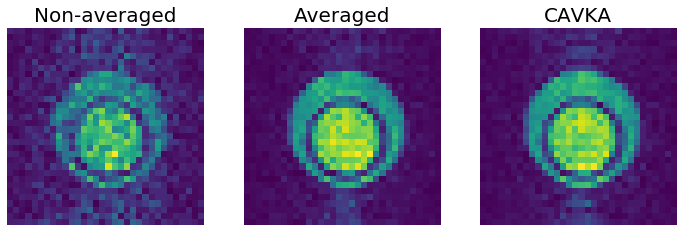

In [11]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1,3,1)
plt.imshow(kspace_to_image(ref_data.k_space)[3,:,:])
ax1.set_title('Non-averaged', size=20)
ax1.set_axis_off()

ax2 = fig.add_subplot(1,3,2)
plt.imshow(kspace_to_image(ref_kspace_avg)[0,:,:])
ax2.set_title('Averaged', size=20)
ax2.set_axis_off()

ax3 = fig.add_subplot(1,3,3)
plt.imshow(cavka_images[3,:,:])
ax3.set_title('CAVKA', size=20)
ax3.set_axis_off()

plt.show()

# Comparison of conventional and CAVKA z-spectrum

In [13]:
conv_data = cavka_data(os.path.join(os.getcwd(), 'example data', 'conv_series'))
conv_images = kspace_to_image(conv_data.k_space)

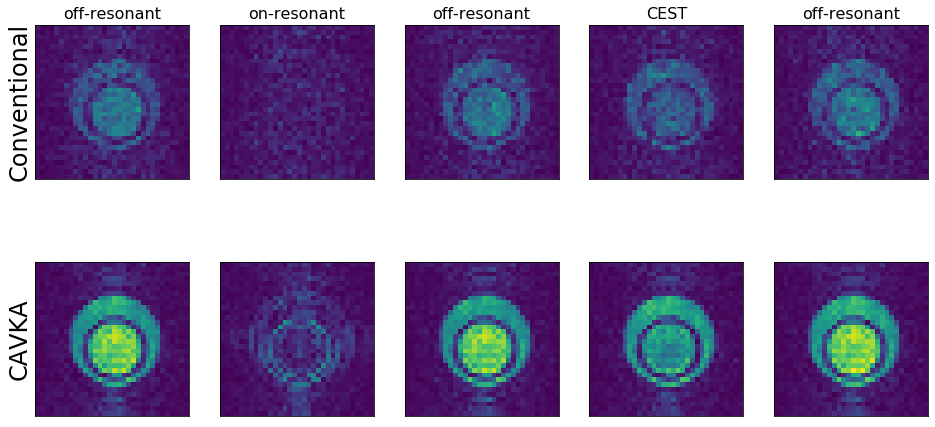

In [23]:
indices = [34, 29, 25, 13, 3]
titles = ['off-resonant', 'on-resonant', 'off-resonant', 'CEST', 'off-resonant']
ax = []
cnorm = colors.Normalize(vmin=np.amin(abs(cavka_images)), vmax=np.amax(abs(cavka_images)), clip=False)
[]

fig = plt.figure(figsize=(16,8))
for i, n in enumerate(indices):
    tax = fig.add_subplot(2,len(indices),i+1)
    tax.set_title(titles[i], size=16)
    ax.append(tax)
    plt.imshow(conv_images[n,:,:], norm=cnorm)
    ax.append(fig.add_subplot(2,len(indices),i+len(indices)+1))
    plt.imshow(cavka_images[n,:,:], norm=cnorm)
    
for x in ax:
    x.set_xticks([])
    x.set_yticks([])
    
ax[0].set_ylabel('Conventional', size=24)
ax[1].set_ylabel('CAVKA', size=24)
    
plt.show()
